# Evalute number of artificial sequences escaping antibodies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
import random
import os
from sklearn.metrics import roc_curve, auc
from scipy.stats import spearmanr

sys.path.append("..")
from global_variables import *
from escape_map import EscapeMap, load_escape_map_from_csv,gen_artif_data, score_seq_batch
from utils import get_Kd

pgm_dir=('../')
sys.path.append(pgm_dir+'./utilities')
import utilities, Proteins_utils, sequence_logo, plots_utils
import rbm, RBM_utils  # rbm.py must be alongside this file




E:\ESCAPE_MAP_DRAFT\PGM\source\numba_utilities.py:1124: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 2, 'F', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  dmean_v_dw = np.dot(s1.T, V)
E:\ESCAPE_MAP_DRAFT\PGM\source\numba_utilities.py:961: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 1, 'A', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  mean_V = np.dot(weights, V) / sum_weights
C:\Users\maria\AppData\Roaming\Python\Python312\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


Loaded 29 KD vectors
Loaded 2 KD vectors
Loaded 671 KD vectors
Loaded 438 KD vectors


# Escape Score

In [2]:
seqs=np.load(open('generated_sequences_ace2tensor(-9.3000)_betatensor(-0.4463).npy','rb'))
random_seqs=np.load(open('random_sequences.npy','rb'))
seqs.shape


(1000, 178)

In [3]:
ic50_db_base=pd.read_csv('../exp_data/cao_data/antibody_ic50s.csv',index_col=0)
ic50_db_base['antibody'] = ic50_db_base.index
ic50_db_base.reset_index(drop=True, inplace=True)  # removes the old index



# WT Ab

In [4]:
log_kd_values=np.array([get_Kd(seq,KD_VECTORS , log10=True) for seq in seqs])
log_kd_values_random=np.array([get_Kd(seq,KD_VECTORS , log10=True) for seq in random_seqs])
ab_names=list(KD_VECTORS.keys())


abs: ['BD30-604' 'BD45-21' 'BD45-70' ... 'BD55-6531' 'XG-017' 'BD55-6390']
lab (4052, 2)
lab (4052, 2)


C:\Users\maria\AppData\Local\Temp\ipykernel_19360\1349932976.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfv['escape'] = ((dfv['IC50'] >= 10.0) | np.isclose(dfv['IC50'], 10.0)).astype(int)


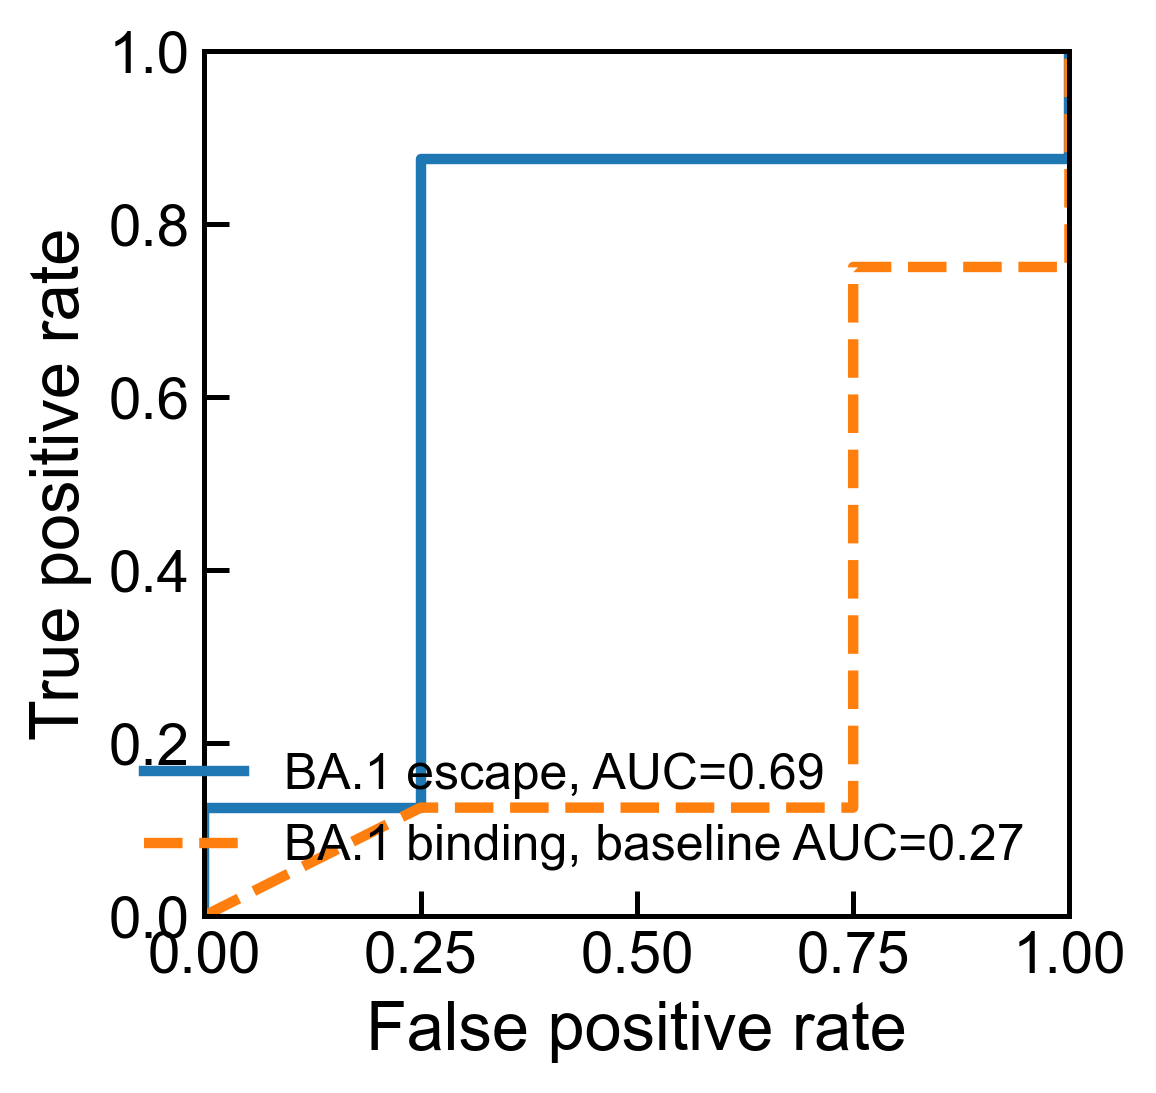

In [5]:


TH = -6.0  # threshold on log10 Kd

fm_df = pd.DataFrame({'antibody': ab_names, 'Fm': (log_kd_values > TH).mean(axis=0), 'Fm_uni': (log_kd_values_random > TH).mean(axis=0)})

ic50_db = ic50_db_base.copy()

print('abs:', ic50_db['antibody'].unique())
# exclude_abs = set(ic50_db[(ic50_db['virus'] == 'D614G') & (ic50_db['IC50'] >= 10.0)]['antibody'].unique())
# fm_keep = fm_df[~fm_df['antibody'].isin(exclude_abs)].copy()
# print(exclude_abs)
fm_keep=fm_df
mpl.rcParams.update({
    'figure.dpi': 300, 'savefig.dpi': 600, 'font.size': 14,
    'axes.titlesize': 16, 'axes.labelsize': 16, 'legend.fontsize': 12,
    'xtick.labelsize': 14, 'ytick.labelsize': 14, 'axes.linewidth': 1.2,
    'xtick.major.size': 6, 'ytick.major.size': 6, 'xtick.major.width': 1.2,
    'ytick.major.width': 1.2, 'xtick.direction': 'in', 'ytick.direction': 'in',
    'pdf.fonttype': 42, 'ps.fonttype': 42, 'font.sans-serif': ['Arial','DejaVu Sans','Helvetica']
})

plt.figure(figsize=(4,4))
ic50_db_grouped = ic50_db.groupby('virus')

for virus in ['BA.1']:
    if virus not in ic50_db_grouped.groups:
        continue
    dfv = ic50_db_grouped.get_group(virus)
    dfv['escape'] = ((dfv['IC50'] >= 10.0) | np.isclose(dfv['IC50'], 10.0)).astype(int)

    # one label per antibody for this virus: escape if any replicate escaped
    lab = dfv.groupby('antibody')['escape'].max().reset_index()
    print('lab', lab.shape)
    # lab = lab[~lab['antibody'].isin(exclude_abs)]  # drop excluded antibodies
    print('lab', lab.shape)

    merged = lab.merge(fm_keep, on='antibody', how='inner')
    if merged['escape'].nunique() < 2:
        continue  # ROC undefined if only one class

    y_true = merged['escape'].values.astype(int)
    y_score = merged['Fm'].values.astype(float)

    fpr, tpr, _ = roc_curve(y_true, y_score)
    A = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2.5,
         label=f'{virus} escape, AUC={A:.2f}')

    y_true = merged['escape'].values.astype(int)
    y_score = merged['Fm_uni'].values.astype(float)

    fpr, tpr, _ = roc_curve(y_true, y_score)
    A = auc(fpr, tpr)
    plt.plot(fpr, tpr,'--', lw=2.5, label=f'{virus} binding, baseline AUC={A:.2f}')



# baseline

ax = plt.gca()
ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.set_aspect('equal', 'box')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.legend(loc='lower right', frameon=False)
plt.tight_layout()
plt.show()




In [6]:
ab_class_df_mapping=pd.read_csv('../exp_data/ab_classification.csv')
class_mapping = ab_class_df_mapping.set_index('condition')['condition_subtype'].to_dict()#condition is ant
class_mapping.update({
    "VIR-7229": "class 1",
    "SA55":     "class 4",
})

In [7]:
MERGED=KD_VECTORS|NEW_KD_VECTORS
log_kd_values=np.array([get_Kd(seq,MERGED , log10=True) for seq in seqs])
log_kd_values_random=np.array([get_Kd(seq,MERGED , log10=True) for seq in random_seqs])
ab_names=list(MERGED.keys())
fm_df = pd.DataFrame({'antibody': ab_names, 'Fm': (log_kd_values > TH).mean(axis=0), 'Fm_uni': (log_kd_values_random > TH).mean(axis=0)})
fm_df


,antibody,Fm,Fm_uni
0,COV2-2050,0.385,0.11700
1,COV2-2082,0.247,0.24350
2,COV2-2094,0.182,0.14400
3,COV2-2096,0.445,0.25400
4,COV2-2130,0.362,0.39325
5,COV2-2165,0.121,0.24325
6,COV2-2196,0.067,0.70850
7,COV2-2479,0.037,0.03450
8,COV2-2499,0.195,0.40400
9,COV2-2677,0.239,0.60175


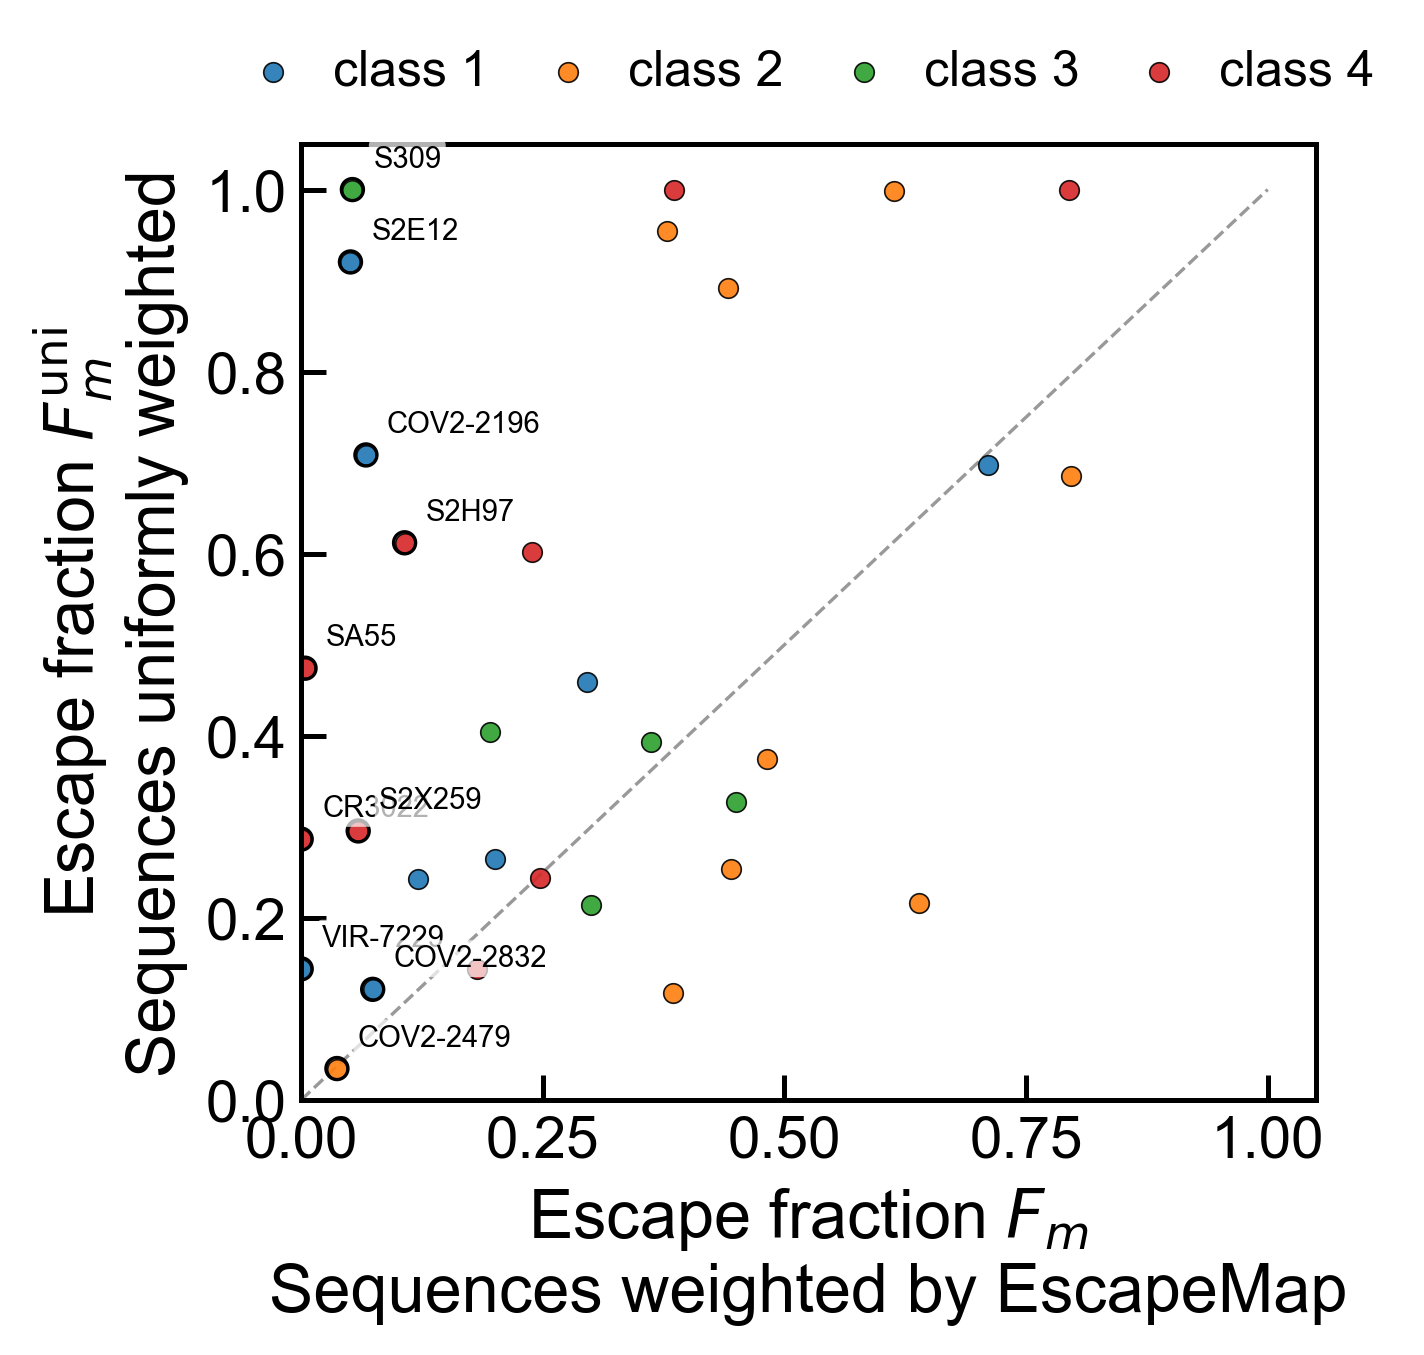

In [8]:
fm_plot = fm_df.copy()
fm_plot["class"] = fm_plot["antibody"].map(class_mapping).fillna("Unclassified")

try:
    nature_rc()
except NameError:
    pass

# --- Class ordering & palette ---
def order_classes(classes):
    import re
    def key(c):
        s = str(c)
        m = re.search(r"(\d+)", s)
        return (0, int(m.group(1))) if m else (1, s.lower())
    return sorted(classes, key=key)

CLASS_COLORS = {
    "class 1": "#1f77b4",
    "class 2": "#ff7f0e",
    "class 3": "#2ca02c",
    "class 4": "#d62728",
}
class_order = order_classes(fm_plot["class"].unique())

# --- Plot (swap axes: x=Fm, y=Fm_uni) ---
fig, ax = plt.subplots(figsize=(4.8, 4.8))

for cls in class_order:
    if cls == "Unclassified" or cls not in CLASS_COLORS:
        continue
    sub = fm_plot[fm_plot["class"] == cls]
    if sub.empty:
        continue
    ax.scatter(
        sub["Fm"], sub["Fm_uni"],                 # <-- swapped here
        s=22, edgecolor="black", linewidth=0.4, alpha=0.9,
        label=str(cls), color=CLASS_COLORS[cls],
    )

# Reference diagonal y=x
ax.plot([0, 1], [0, 1], linestyle="--", linewidth=0.8, color="0.6", zorder=0)

# --- annotate top-10 antibodies with lowest Fm ---
top10 = fm_plot.nsmallest(10, "Fm")
for _, r in top10.iterrows():
    ax.scatter(r["Fm"], r["Fm_uni"], s=28, facecolor="none", edgecolor="k", linewidth=0.8, zorder=3)
    ax.annotate(
        r["antibody"],
        xy=(r["Fm"], r["Fm_uni"]),
        xytext=(5, 4), textcoords="offset points",
        fontsize=7, ha="left", va="bottom",
        bbox=dict(boxstyle="round,pad=0.15", fc="white", ec="none", alpha=0.7),
        zorder=4
    )

ax.set_xlim(0, 1.05); ax.set_ylim(0, 1.05)
ax.set_xlabel( r"Escape fraction $F_m$" "\n" "Sequences weighted by EscapeMap" )
ax.set_ylabel( r"Escape fraction $F_m^{\mathrm{uni}}$" "\n" "Sequences uniformly weighted" )


handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles, labels,
    ncol=len(labels),                 # one line
    loc="upper center",
    bbox_to_anchor=(0.5, 1.12),       # a bit above the plot
    frameon=False,                    # Nature-ish; set True if you want a box
    handlelength=1.2, handletextpad=0.6, columnspacing=1.0, borderaxespad=0.0
)

plt.tight_layout()
plt.show()


In [9]:

fm_per_ab = (
    fm_plot
    .groupby("antibody", as_index=False)
    .agg(
        Fm=("Fm", "mean"),
        Fm_uni=("Fm_uni", "mean"),
        n=("Fm", "size"),
    )
)

# attach a stable class per antibody (mode; fallback to 'Unclassified')
cls_per_ab = (
    fm_plot.groupby("antibody")["class"]
    .agg(lambda s: s.mode().iat[0] if not s.mode().empty else "Unclassified")
    .reset_index()
)

fm_per_ab = (
    fm_per_ab
    .merge(cls_per_ab, on="antibody", how="left")
    .rename(columns={"class": "Class"})
    [["antibody", "Class", "Fm", "Fm_uni", "n"]]
    .sort_values(["Class", "Fm"], ascending=[True, True])
    .reset_index(drop=True)
)

# Keep a named copy as the final dataset
df_fm_dataset = fm_per_ab.copy()

# Optional: save to disk
df_fm_dataset.to_csv("fm_per_antibody.csv", index=False)


# Map

In [10]:
VOCS=Proteins_utils.load_FASTA('../seq_data/sequences_vocs.fasta', drop_duplicates=False)[:,BEGIN:-END]

log_kd_values_vocs=np.array([get_Kd(seq,KD_VECTORS , log10=True) for seq in VOCS])

# ---- parse names + sequences from FASTA ----
fasta_path = Path("../seq_data/sequences_vocs.fasta")

voc_names: list[str] = []
with fasta_path.open() as f:
    name = None
    seq_chunks = []
    for line in f:
        line = line.strip()
        if not line:
            continue
        if line.startswith(">"):
            if name is not None:
                voc_names.append(name)
            name = line[1:].strip()          # e.g., "Alpha"
            seq_chunks = []
        else:
            seq_chunks.append(line)
    # flush last
    if name is not None:
        voc_names.append(name)


# ---- pick the two antibodies and build a dict {name: (k_S309, k_LY-CoV016)} ----
def _find_key(keys, target):
    t = target.lower().replace("-", "").replace("_", "")
    for i, k in enumerate(keys):
        kk = k.lower().replace("-", "").replace("_", "")
        if kk == t:
            return i
    raise KeyError(f"Antibody '{target}' not found in KD_VECTORS: {list(keys)}")

ab_names = list(KD_VECTORS.keys())
ix_s309 = _find_key(ab_names, "S309")
ix_ly16 = _find_key(ab_names, "LY-CoV016")

voc_points = {
    nm: (log_kd_values_vocs[i, ix_s309], log_kd_values_vocs[i, ix_ly16])
    for i, nm in enumerate(voc_names) if nm in ['WT', 'BA.1', 'BA.5']
}
print(voc_points)

{'BA.1': (-6.541719230786223, -5.996622119333728), 'BA.5': (-6.433856802550101, -5.418993678633301), 'WT': (-7.102372908709557, -8.086186147616283)}


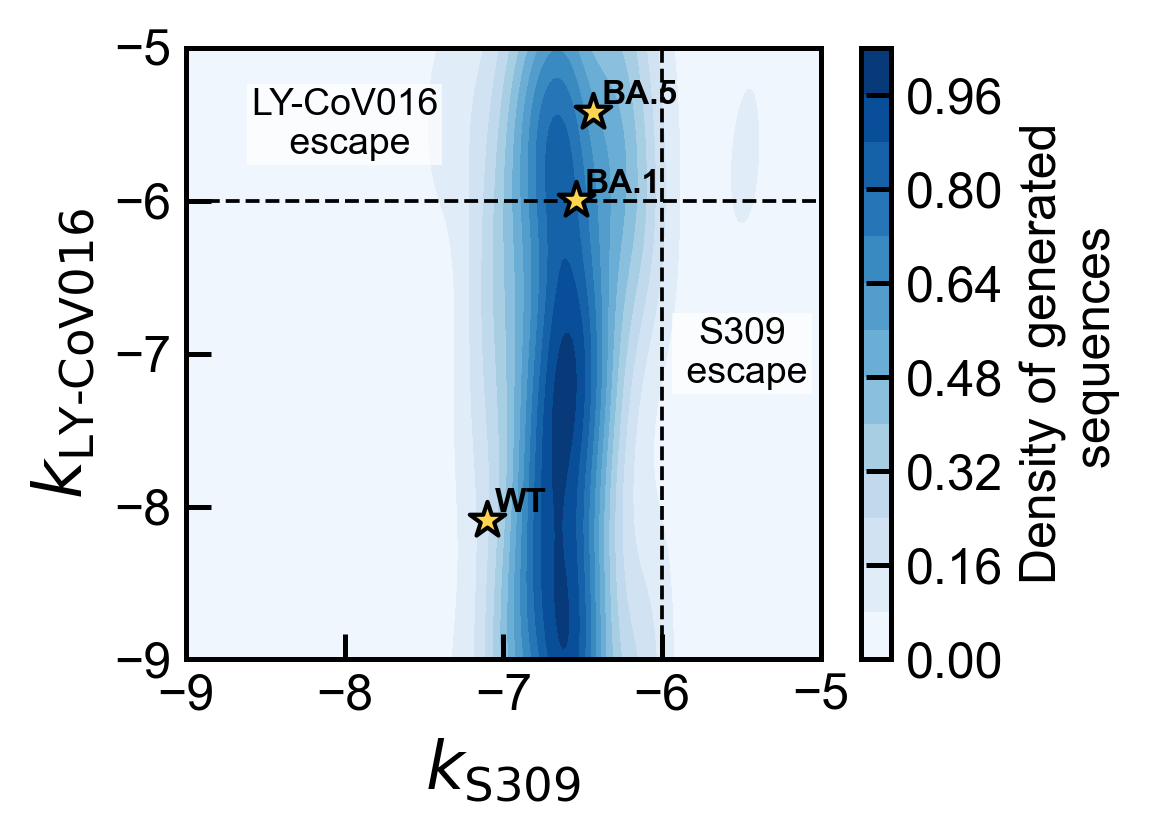

In [11]:
def _find_key(keys, target):
    t = target.lower().replace("-", "").replace("_", "")
    for i, k in enumerate(keys):
        kk = k.lower().replace("-", "").replace("_", "")
        if kk == t:
            return i
    raise KeyError(f"Antibody '{target}' not found in: {keys}")

ix_s309 = _find_key(ab_names, "S309")
ix_ly16 = _find_key(ab_names, "LY-CoV016")

x = log_kd_values[:, ix_s309]
y = log_kd_values[:, ix_ly16]

xlim = (-9, -5)
ylim = (-9, -5)

fig, ax = plt.subplots(figsize=(4, 3))

# --- KDE density (smooth like your figure) ---
try:
    from scipy.stats import gaussian_kde
    values = np.vstack([x, y])
    kde = gaussian_kde(values)
    xx, yy = np.meshgrid(np.linspace(*xlim, 200), np.linspace(*ylim, 200))
    zz = kde(np.vstack([xx.ravel(), yy.ravel()])).reshape(xx.shape)
    zz = zz / zz.max()
    cntr = ax.contourf(xx, yy, zz, levels=12, cmap="Blues")
except Exception:
    cntr = ax.hist2d(x, y, bins=60, range=[xlim, ylim], cmap="Blues", density=True)[3]

# colorbar
cbar = fig.colorbar(cntr, ax=ax)
cbar.set_label("Density of generated\n sequences", fontsize=12)

# axes labels and limits
ax.set_xlabel(r"$k_{\mathrm{S309}}$")
ax.set_ylabel(r"$k_{\mathrm{LY\text{-}CoV016}}$")
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)

# ticks every unit
ax.set_xticks(np.arange(xlim[0], xlim[1] + 1, 1))
ax.set_yticks(np.arange(ylim[0], ylim[1] + 1, 1))

# dashed guide lines at -6
ax.axvline(-6, ls="--", lw=0.9, color="black")
ax.axhline(-6, ls="--", lw=0.9, color="black")

# region labels
ax.text(-8.0, -5.5, "LY-CoV016\n escape", fontsize=9,
        ha="center", va="center",
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=1.0))
ax.text(-5.5, -7.0, "S309\n escape", fontsize=9,
        ha="center", va="center",
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=1.0))

# VOC points
for name, (vx, vy) in voc_points.items():
    ax.scatter(vx, vy, marker="*", s=80, edgecolor="black", facecolor="#FFD54F", zorder=3)
    ax.text(vx+0.05, vy+0.05, name, fontsize=8, weight="bold",
            bbox=dict(facecolor="none", edgecolor="none", alpha=0.8, pad=1.5))
# smaller tick labels on axes
ax.tick_params(axis="both", which="both", labelsize=12)

# smaller tick labels on the colorbar
cbar.ax.tick_params(labelsize=12)

fig.tight_layout()
plt.show()


# Cocktails

                           combo     Fm
0  REGN10987+\nREGN10933+\nS2X58  0.041
1          REGN10987+\nREGN10933  0.077
2          REGN10987+\nLY-CoV016  0.144
3                      REGN10933  0.201
4                      REGN10987  0.450


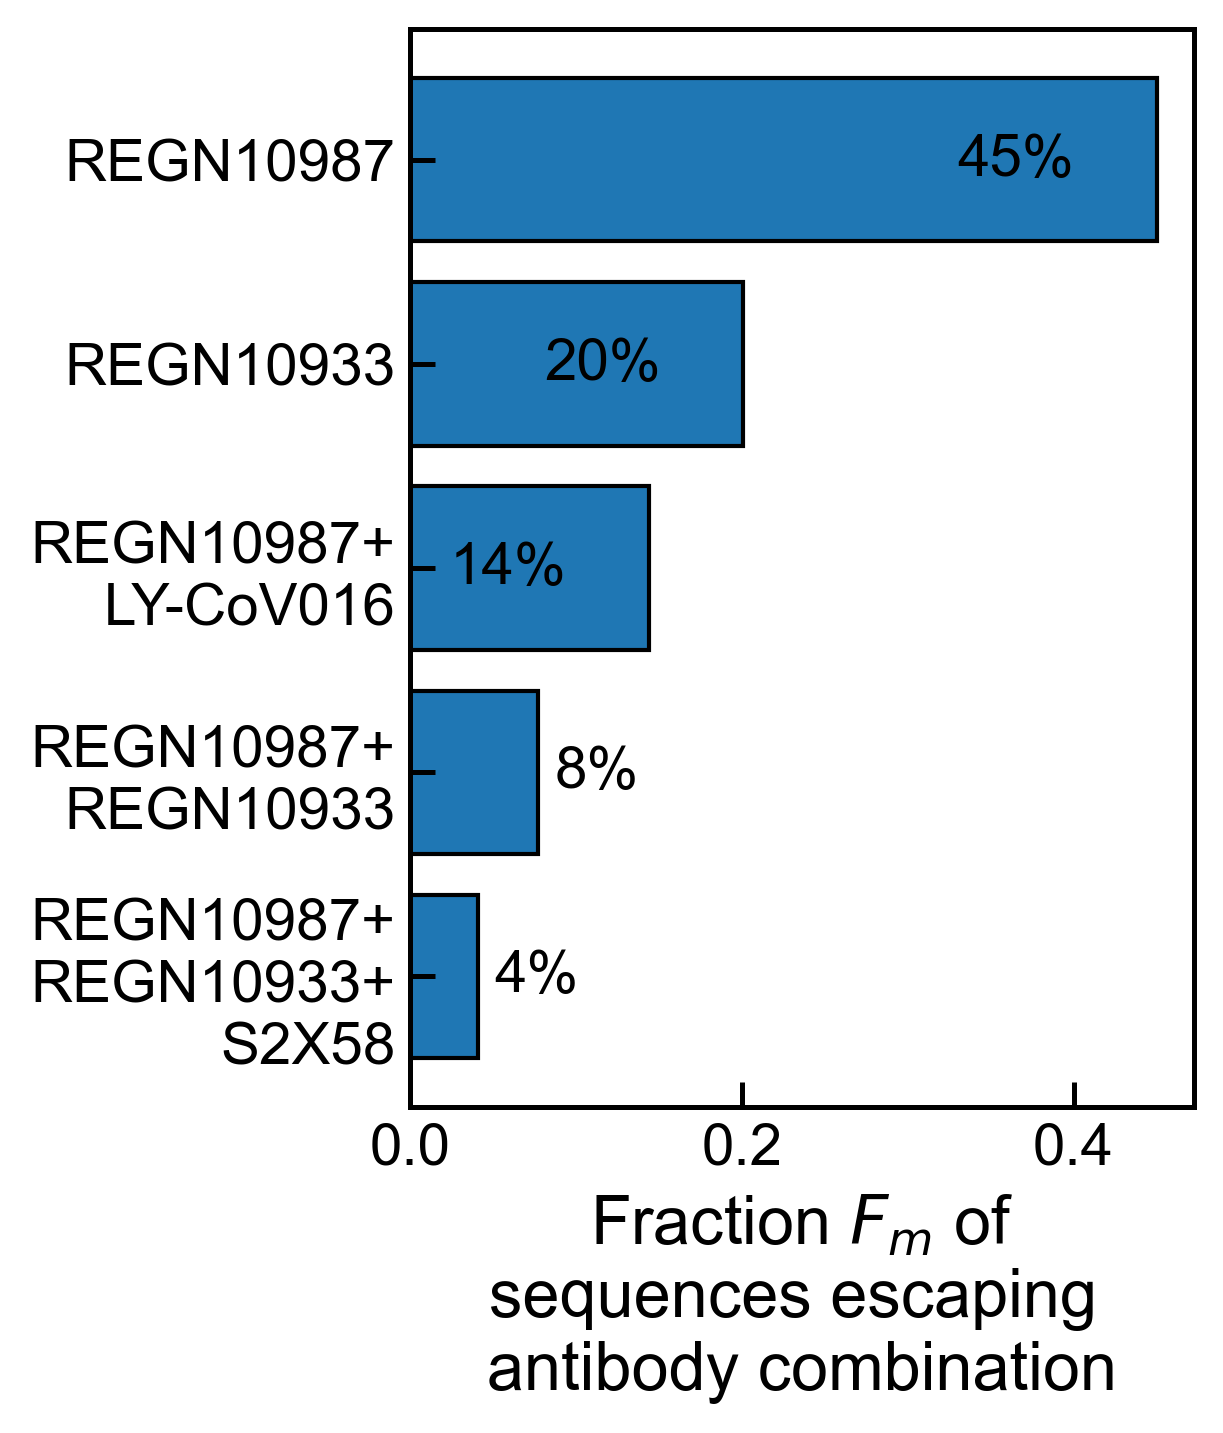

In [12]:
# --- Helper: robust antibody name matching (ignore case, dashes/underscores/spaces) ---
def _norm(s: str) -> str:
    return "".join(ch for ch in s.lower() if ch.isalnum())

def _find_ab_ix(ab_names, target):
    t = _norm(target)
    for i, name in enumerate(ab_names):
        if _norm(name) == t:
            return i
    raise KeyError(f"Antibody '{target}' not found in ab_names: {ab_names}")

# --- Build index map for antibodies you care about ---
ab_map = {name: _find_ab_ix(ab_names, name) for name in ["REGN10933", "REGN10987", "S2X58", "LY-CoV016"]}

# --- Define combos (each as a tuple of antibody names for clarity/order) ---
combos = [
    ("REGN10987","REGN10933" , "S2X58"),
        ("REGN10987","REGN10933" ),
        ("REGN10987","LY-CoV016"),
        ("REGN10933",),
    ("REGN10987",),
]
def combos2labels(combos):
    labels = []
    for c in combos:
        if len(c) == 1:
            labels.append(c[0])
        else:
            labels.append("+\n".join(c))
    return labels
combo_labels = combos2labels(combos)

# --- Compute Fm for each combo: ALL antibodies in the combo must exceed TH ---
def combo_Fm(logkd_matrix, combo):
    idxs = [ab_map[a] for a in combo]
    # shape: (n_seq, len(combo)) -> True if ALL antibodies in combo exceed TH for a given sequence
    escaped_all = (logkd_matrix[:, idxs] > TH).all(axis=1)
    return escaped_all.mean()

fm_vals = [combo_Fm(log_kd_values, c) for c in combos]

# Optional: baseline on random sequences if available
fm_uni_vals = None


# --- Pack results in a DataFrame ---
out_cols = {"combo": combo_labels, "Fm": fm_vals}
if fm_uni_vals is not None:
    out_cols["Fm_uni"] = fm_uni_vals
fm_combos_df = pd.DataFrame(out_cols)
print(fm_combos_df)

# --- Plot: horizontal bar chart (no grid), annotate with percentages ---
fig, ax = plt.subplots(figsize=(4.3, 5))
bars = ax.barh(combo_labels, fm_vals, edgecolor="black", linewidth=1)

ax.set_xlabel(r"Fraction $F_m$ of" +"\n" +r"sequences escaping " +"\n" +r"antibody combination")
# ax.set_ylabel("Antibody combination")
ax.grid(False)

# Annotate bars
for b, v in zip(bars, fm_vals):
    if v>0.1:
        ax.text(v-0.12 , b.get_y() + b.get_height()/2, f"{v:.0%}", va="center", ha="left", fontsize=14)
    else: 
        ax.text(v+0.01 , b.get_y() + b.get_height()/2, f"{v:.0%}", va="center", ha="left", fontsize=14)



plt.tight_layout()
plt.show()


# Triple correlation

Building cocktails with LY-CoV016 and LY-CoV555...

--- Analysis Results ---
         ab_3 ab_3_class                         cocktail_str     Fm  \
0   COV2-2050    class 2  LY-CoV016\n+ LY-CoV555\n+ COV2-2050  0.155   
1   COV2-2082    class 4  LY-CoV016\n+ LY-CoV555\n+ COV2-2082  0.060   
2   COV2-2094    class 4  LY-CoV016\n+ LY-CoV555\n+ COV2-2094  0.046   
3   COV2-2096    class 2  LY-CoV016\n+ LY-CoV555\n+ COV2-2096  0.132   
4   COV2-2130    class 3  LY-CoV016\n+ LY-CoV555\n+ COV2-2130  0.096   
5   COV2-2165    class 1  LY-CoV016\n+ LY-CoV555\n+ COV2-2165  0.032   
6   COV2-2196    class 1  LY-CoV016\n+ LY-CoV555\n+ COV2-2196  0.023   
7   COV2-2479    class 2  LY-CoV016\n+ LY-CoV555\n+ COV2-2479  0.018   
8   COV2-2499    class 3  LY-CoV016\n+ LY-CoV555\n+ COV2-2499  0.022   
9   COV2-2677    class 4  LY-CoV016\n+ LY-CoV555\n+ COV2-2677  0.064   
10  COV2-2832    class 1  LY-CoV016\n+ LY-CoV555\n+ COV2-2832  0.030   
11     CR3022    class 4     LY-CoV016\n+ LY-CoV555\n+ CR30

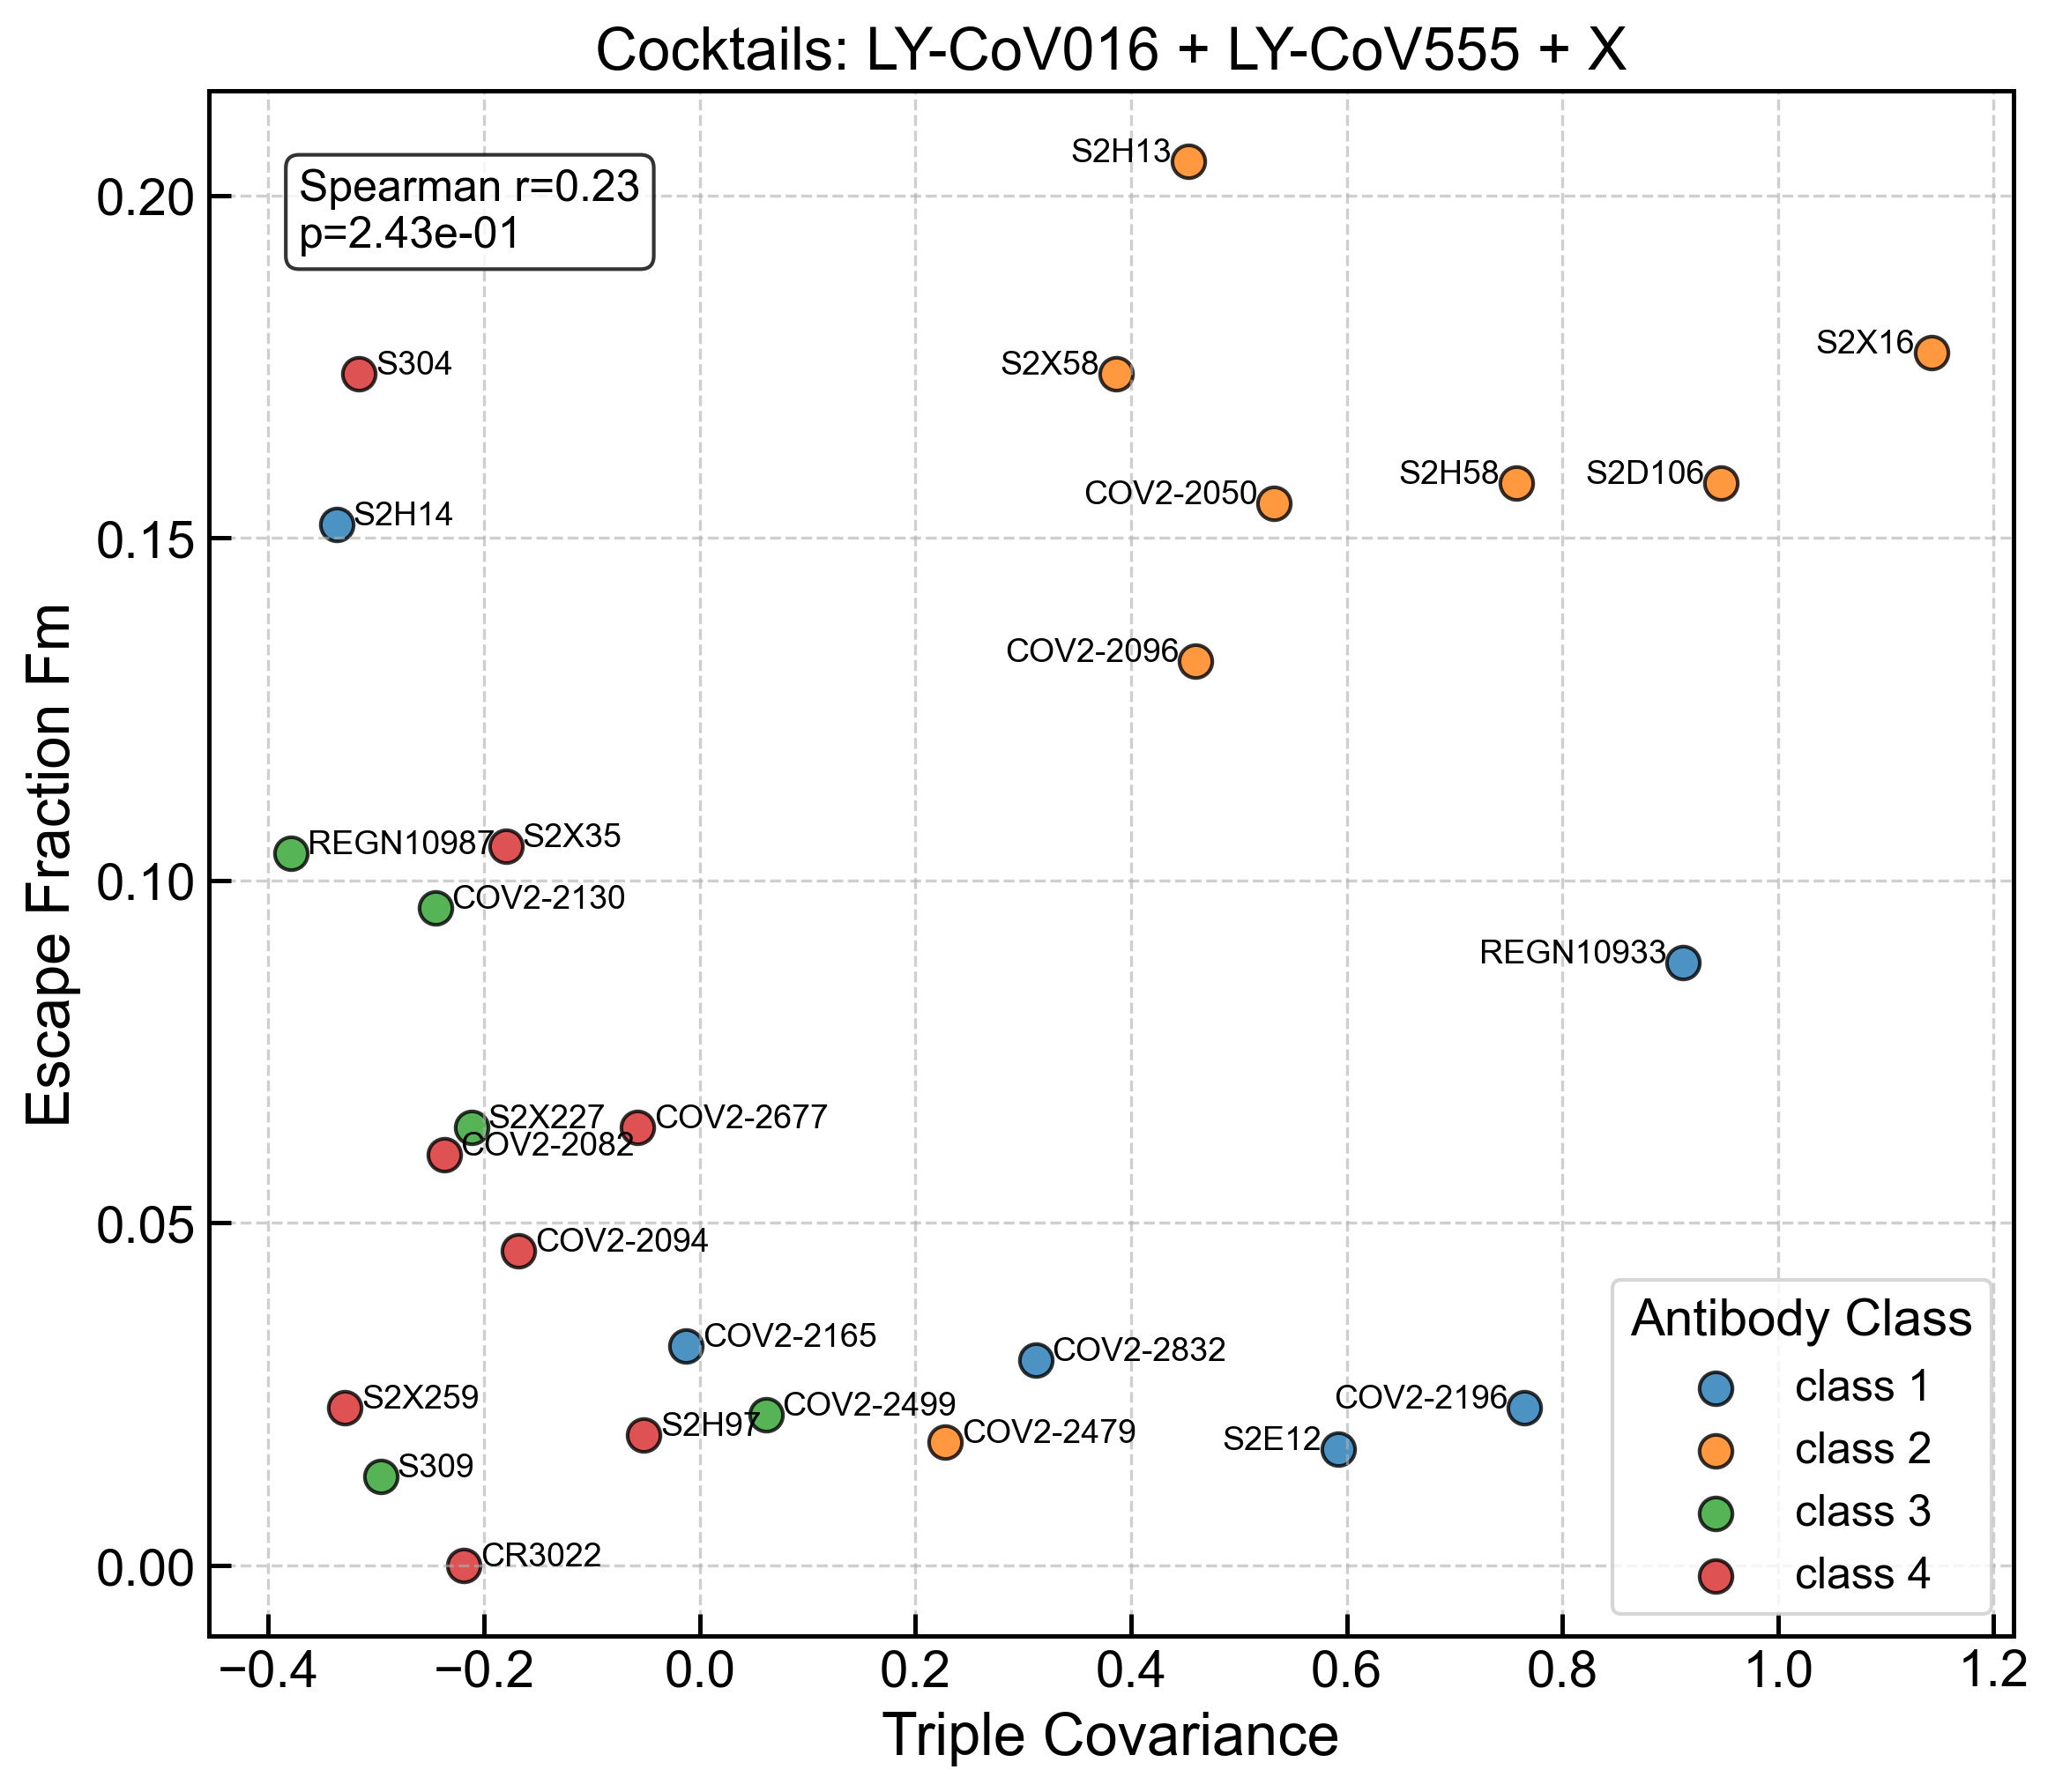

In [13]:
def _norm(s: str) -> str:
    """Normalize antibody names for comparison."""
    return "".join(ch for ch in s.lower() if ch.isalnum())

def _find_ab_ix(ab_names, target):
    """Find the index of a target antibody in the name list."""
    t = _norm(target)
    for i, name in enumerate(ab_names):
        if _norm(name) == t:
            return i
    raise KeyError(f"Antibody '{target}' not found in ab_names: {ab_names}")

# --- Calculation Functions ---

def compute_Fm(log_kd_matrix, cocktail, ab_map, threshold):
    """
    Compute Fm: Fraction of sequences where all antibodies in the cocktail
    are above the threshold.
    """
    # Get the column indices for the antibodies in this cocktail
    idxs = [ab_map[name] for name in cocktail]
    
    # Select the data for these antibodies (shape: N_sequences, 3)
    cocktail_data = log_kd_matrix[:, idxs]
    

    escaped_all = (cocktail_data > threshold).all(axis=1)
    
    return escaped_all.mean()

def compute_triple_moment(log_kd_matrix, cocktail, ab_map):
    """
    Compute the 3rd-order central moment (triple covariance) for the cocktail.
    E[(X - E[X]) * (Y - E[Y]) * (Z - E[Z])]
    """
    # Get the column indices
    idxs = [ab_map[name] for name in cocktail]
    
    # Select the data (shape: N_sequences, 3)
    data = log_kd_matrix[:, idxs]
    
    # Calculate the means for each antibody (E[X], E[Y], E[Z])
    means = data.mean(axis=0)
    
    # Center the data (X - E[X], Y - E[Y], Z - E[Z])
    centered_data = data - means
    
    # Calculate the product of centered variables for each sequence
    # (X-E[X]) * (Y-E[Y]) * (Z-E[Z])
    product = centered_data.prod(axis=1)
    
    # The triple moment is the mean of this product
    return product.mean()




# --- 2. ANALYSIS SETUP ---
TH = -6.0
FIXED_AB_1 = "LY-CoV016"
FIXED_AB_2 = "LY-CoV555" # Using your corrected name

# Class colors as provided
CLASS_COLORS = {
    "class 1": "#1f77b4",
    "class 2": "#ff7f0e",
    "class 3": "#2ca02c",
    "class 4": "#d62728",
    "Other": "#7f7f7f" # Fallback color
}

# Build a map of {Antibody Name: Index} for all antibodies
try:
    # This will fail if ab_names is not defined, which is intended.
    ab_map = {name: i for i, name in enumerate(ab_names)}
    
    # Get normalized names for comparison
    norm_ab1 = _norm(FIXED_AB_1)
    norm_ab2 = _norm(FIXED_AB_2)

    # --- 3. MAIN CALCULATION LOOP ---
    results = []

    print(f"Building cocktails with {FIXED_AB_1} and {FIXED_AB_2}...")

    # Iterate over all antibodies to find the 3rd member
    for ab3_name in ab_names:
        norm_ab3 = _norm(ab3_name)
        
        # Check if this is a different antibody
        if norm_ab3 != norm_ab1 and norm_ab3 != norm_ab2:
            # We found a valid 3rd antibody
            cocktail = (FIXED_AB_1, FIXED_AB_2, ab3_name)
            
            # Perform calculations
            # Note: Using log_kd_values (assumed to be loaded)
            fm = compute_Fm(log_kd_values, cocktail, ab_map, TH)
            triple_cov = compute_triple_moment(log_kd_values, cocktail, ab_map)
            
            # Get the class for the 3rd antibody
            ab_class = class_mapping.get(ab3_name, "Other") # Default to "Other"
            
            # Store results
            results.append({
                "ab_3": ab3_name,
                "ab_3_class": ab_class,
                "cocktail_str": f"{FIXED_AB_1}\n+ {FIXED_AB_2}\n+ {ab3_name}",
                "Fm": fm,
                "triple_covariance": triple_cov
            })

    # --- 4. STORE AND PLOT RESULTS ---
    if not results:
        print("No valid 3-antibody cocktails found. Check 'ab_names'.")
    else:
        # Convert results to a DataFrame
        results_df = pd.DataFrame(results)
        
        print("\n--- Analysis Results ---")
        print(results_df)
        print("--------------------------\n")


        fig, ax = plt.subplots(figsize=(8, 7))

        # Group by class to plot with different colors
        for ab_class, group in results_df.groupby('ab_3_class'):
            ax.scatter(
                group['triple_covariance'], 
                group['Fm'],
                s=80, # size
                alpha=0.8,
                edgecolors='k',
                color=CLASS_COLORS.get(ab_class, "#7f7f7f"), # Use color map
                label=ab_class # Add label for legend
            )

        # --- Smart Text Labeling ---
        x_min = results_df['triple_covariance'].min()
        x_max = results_df['triple_covariance'].max()
        x_center = (x_min + x_max) / 2
        x_padding = (x_max - x_min) * 0.01 # Use 1% of the range as padding

        # 5. Add labels, smartly adjusting alignment
        for i, row in results_df.iterrows():
            # Decide on alignment and offset
            if row['triple_covariance'] > x_center:
                ha = 'right' # Align text to the right
                offset = -x_padding # Put text to the left of the point
            else:
                ha = 'left' # Align text to the left
                offset = x_padding # Put text to the right of the point
            
            ax.text(
                row['triple_covariance'] + offset, # Apply smart offset
                row['Fm'], 
                row['ab_3'], # label with the 3rd Ab name
                fontsize=9,
                ha=ha # Apply smart alignment
            )
        spearman_corr, p_value = spearmanr(results_df['triple_covariance'], results_df['Fm'])
        plt.text(0.05, 0.95, f'Spearman r={spearman_corr:.2f}\np={p_value:.2e}', transform=ax.transAxes,
                 fontsize=12, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        ax.set_title(f"Cocktails: {FIXED_AB_1} + {FIXED_AB_2} + X", fontsize=16)
        ax.set_xlabel("Triple Covariance", fontsize=16)
        ax.set_ylabel("Escape Fraction Fm", fontsize=16)

        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend(title="Antibody Class") # Add the legend
        
        fig.tight_layout()
        
        print("Displaying plot...")
        plt.show()

except KeyError as e:
    print(f"Error: {e}")
    print(f"Please ensure '{FIXED_AB_1}' and '{FIXED_AB_2}' are in your 'ab_names' list.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")



Displaying bar plot...


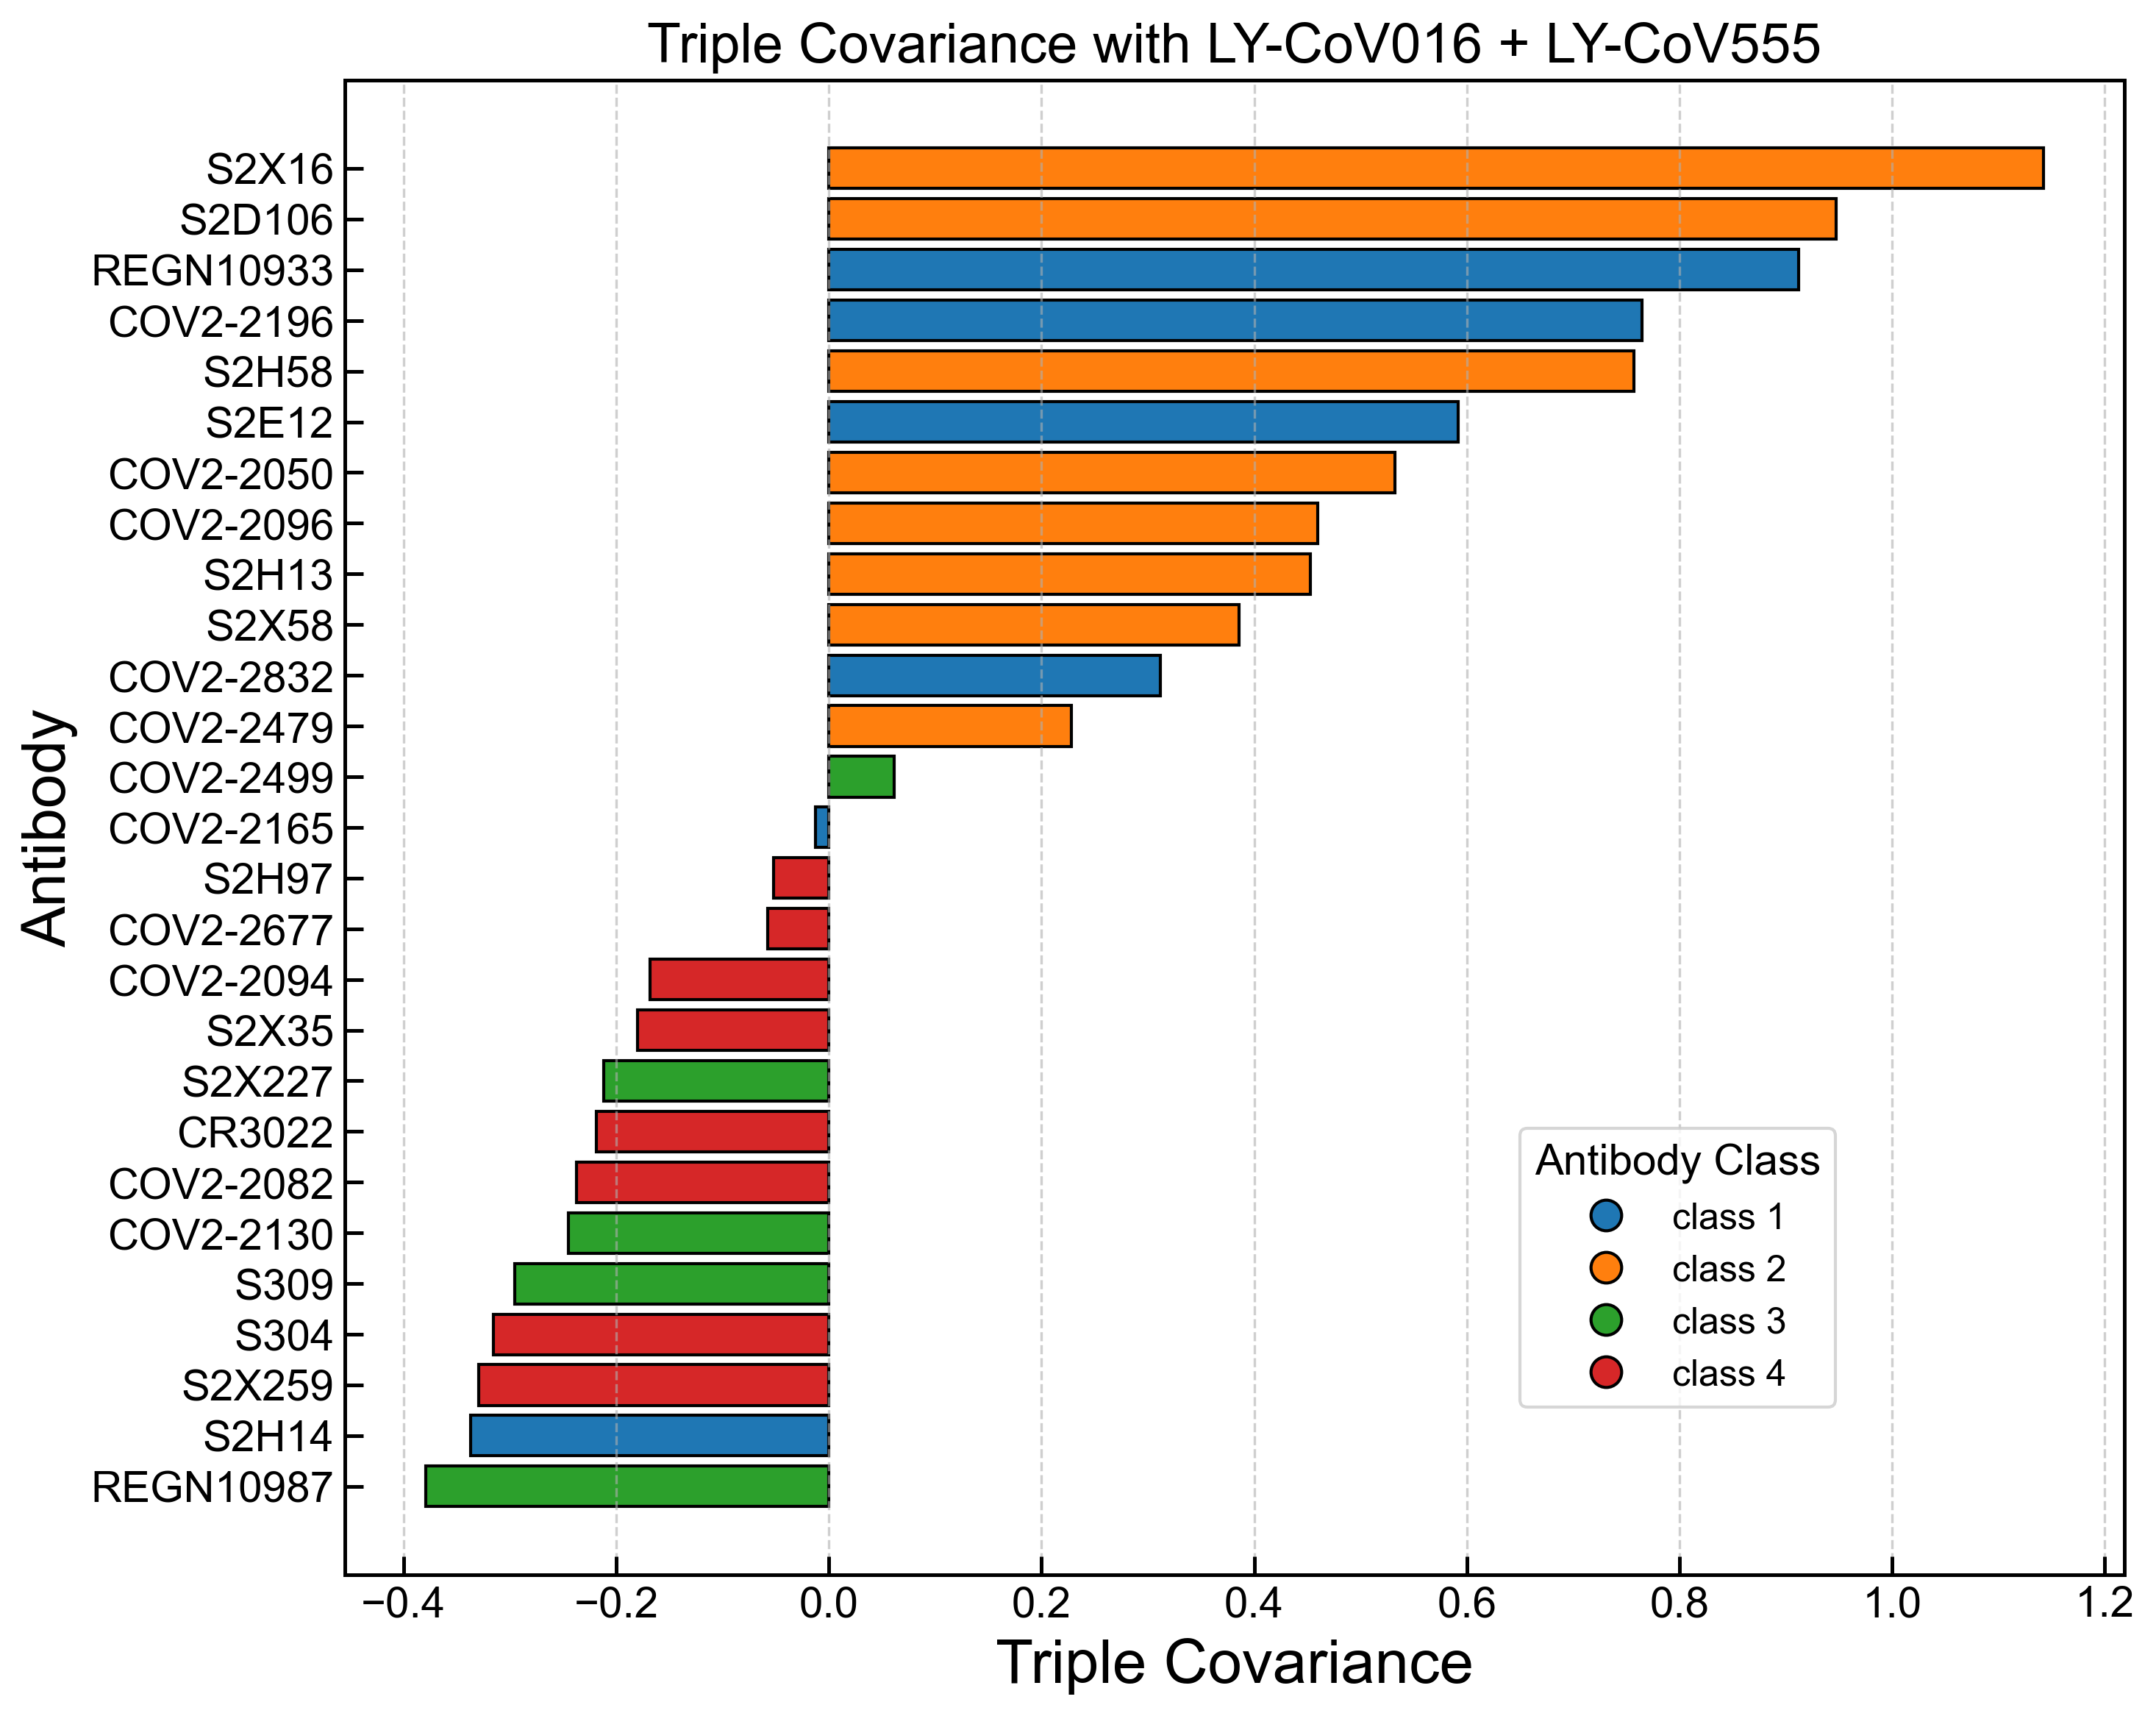

In [14]:


sorted_df = results_df.sort_values('triple_covariance', ascending=False)

bar_colors = sorted_df['ab_3_class'].map(lambda c: CLASS_COLORS.get(c, "#7f7f7f")).tolist()

# Create the figure and axes
# Adjust height based on the number of antibodies
num_abs = len(sorted_df)
fig_height = max(8, num_abs * 0.2) # 0.5 inches per bar, min 8
fig_bar, ax_bar = plt.subplots(figsize=(10, fig_height))

# Create the horizontal bar plot
ax_bar.barh(
    sorted_df['ab_3'], 
    sorted_df['triple_covariance'], 
    color=bar_colors,
    edgecolor='k'
)

# Invert y-axis to show highest covariance at the top
ax_bar.invert_yaxis()

ax_bar.set_xlabel("Triple Covariance", fontsize=20)
ax_bar.set_ylabel("Antibody", fontsize=20)
ax_bar.set_title(f"Triple Covariance with {FIXED_AB_1} + {FIXED_AB_2}", fontsize=18)


unique_classes = sorted_df['ab_3_class'].unique()
legend_elements = []

# Create handles for all classes in the color map that are in the data
unique_classes_sorted = order_classes(unique_classes)
for cls in unique_classes_sorted:
    color = CLASS_COLORS.get(cls, "#7f7f7f")
    legend_elements.append(
        plt.Line2D([0], [0], marker='o', color='w', label=cls,
                   markerfacecolor=color, markersize=10, markeredgecolor='k')
    )
        
# Only add legend if there are elements
if legend_elements:
        ax_bar.legend(handles=legend_elements, title="Antibody Class", bbox_to_anchor=(0.65, 0.1), loc='lower left')

ax_bar.grid(True, linestyle='--', alpha=0.6, axis='x')

# Use tight_layout
fig_bar.tight_layout() 

print("Displaying bar plot...")
plt.show()